Этот набор данных используется для прогнозирования вероятности инсульта у пациента на основе таких входных параметров, как пол, возраст, различные заболевания и статус курения. Каждая строка в данных содержит соответствующую информацию о пациенте.

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Информация атрибутов датасета:

1) id: уникальный идентификатор

2) gender: гендер ("Male", "Female" или "Other")

3) age: возраст пациента

4) hypertension: 0 если пациент не имеет гипертонию, 1 если пациент имеет гипертонию

5) heart_disease: 0 если пациент не имеет болезней серда, 1 если пациент имеет болезни сердца

6) ever_married: был в браке "No" или "Yes"

7) work_type: тип занятости ("children", "Govt_jov", "Never_worked", "Private" or "Self-employed")

8) Residence_type: село или город ("Rural" or "Urban")

9) avg_glucose_level: средний уровень глюкозы в крови

10) bmi: индекс массы тела

11) smoking_status: статус курения ("formerly smoked", "never smoked", "smokes" or "Unknown")

12) stroke: 1 если пациент имел инсульт или 0 если не имел инсульта.

Задача может быть охарактеризована как задача бинарной классификации.

Мы сперва посмотрим на датасет и проведём первичный анализ данных. Затем обучим модель различными подходами и подберём лучшие гиперпараметры максимизируя метрику ROC AUC и сравним результаты работы алгоритмов. А также посмотрим на значимость признаков.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'png2x'
sns.set(style='darkgrid', palette="Set2", context='notebook')
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.info() # посмотрим на датасет через метод info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# Первым делом разделим для удобства признаки на числовые и катагориальные

# Числовые признаки
num_cols = [
    'age',
    'avg_glucose_level',
    'bmi'
]


# Категориальные признаки
cat_cols = [
    'gender',
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status'
]

feature_cols = num_cols + cat_cols

# Таргет
target_col = ['stroke']

In [5]:
(data.shape[0] - data.dropna().shape[0]) / data.shape[0] * 100 # % пропущенных значений

3.9334637964774952

In [6]:
data = data.drop('id', axis=1)

In [7]:
# избавимся от пропусков
data = data.dropna()

In [8]:
data.shape

(4909, 11)

In [9]:
data.describe() # посмотрим статистики для численных признаков

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.865374,0.091872,0.049501,105.305150,28.893237,0.042575
std,22.555115,0.288875,0.216934,44.424341,7.854067,0.201917
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


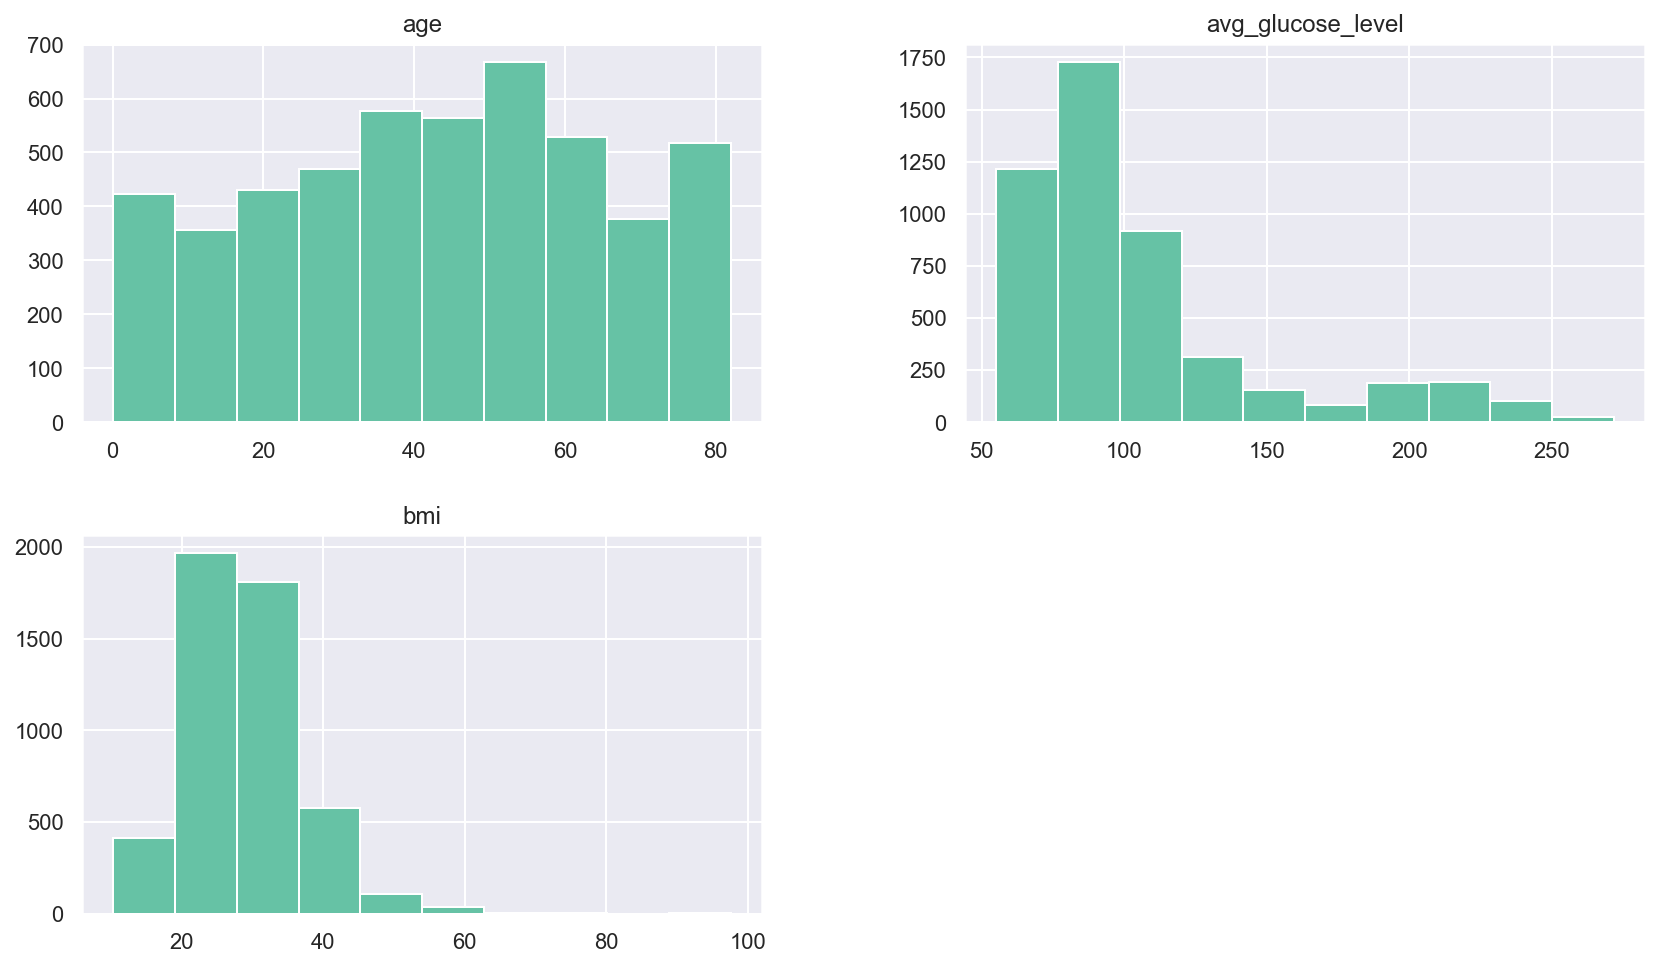

In [10]:
data.hist(column=num_cols, figsize=(14, 8)); # посмотрим гистограммы для численных признаков

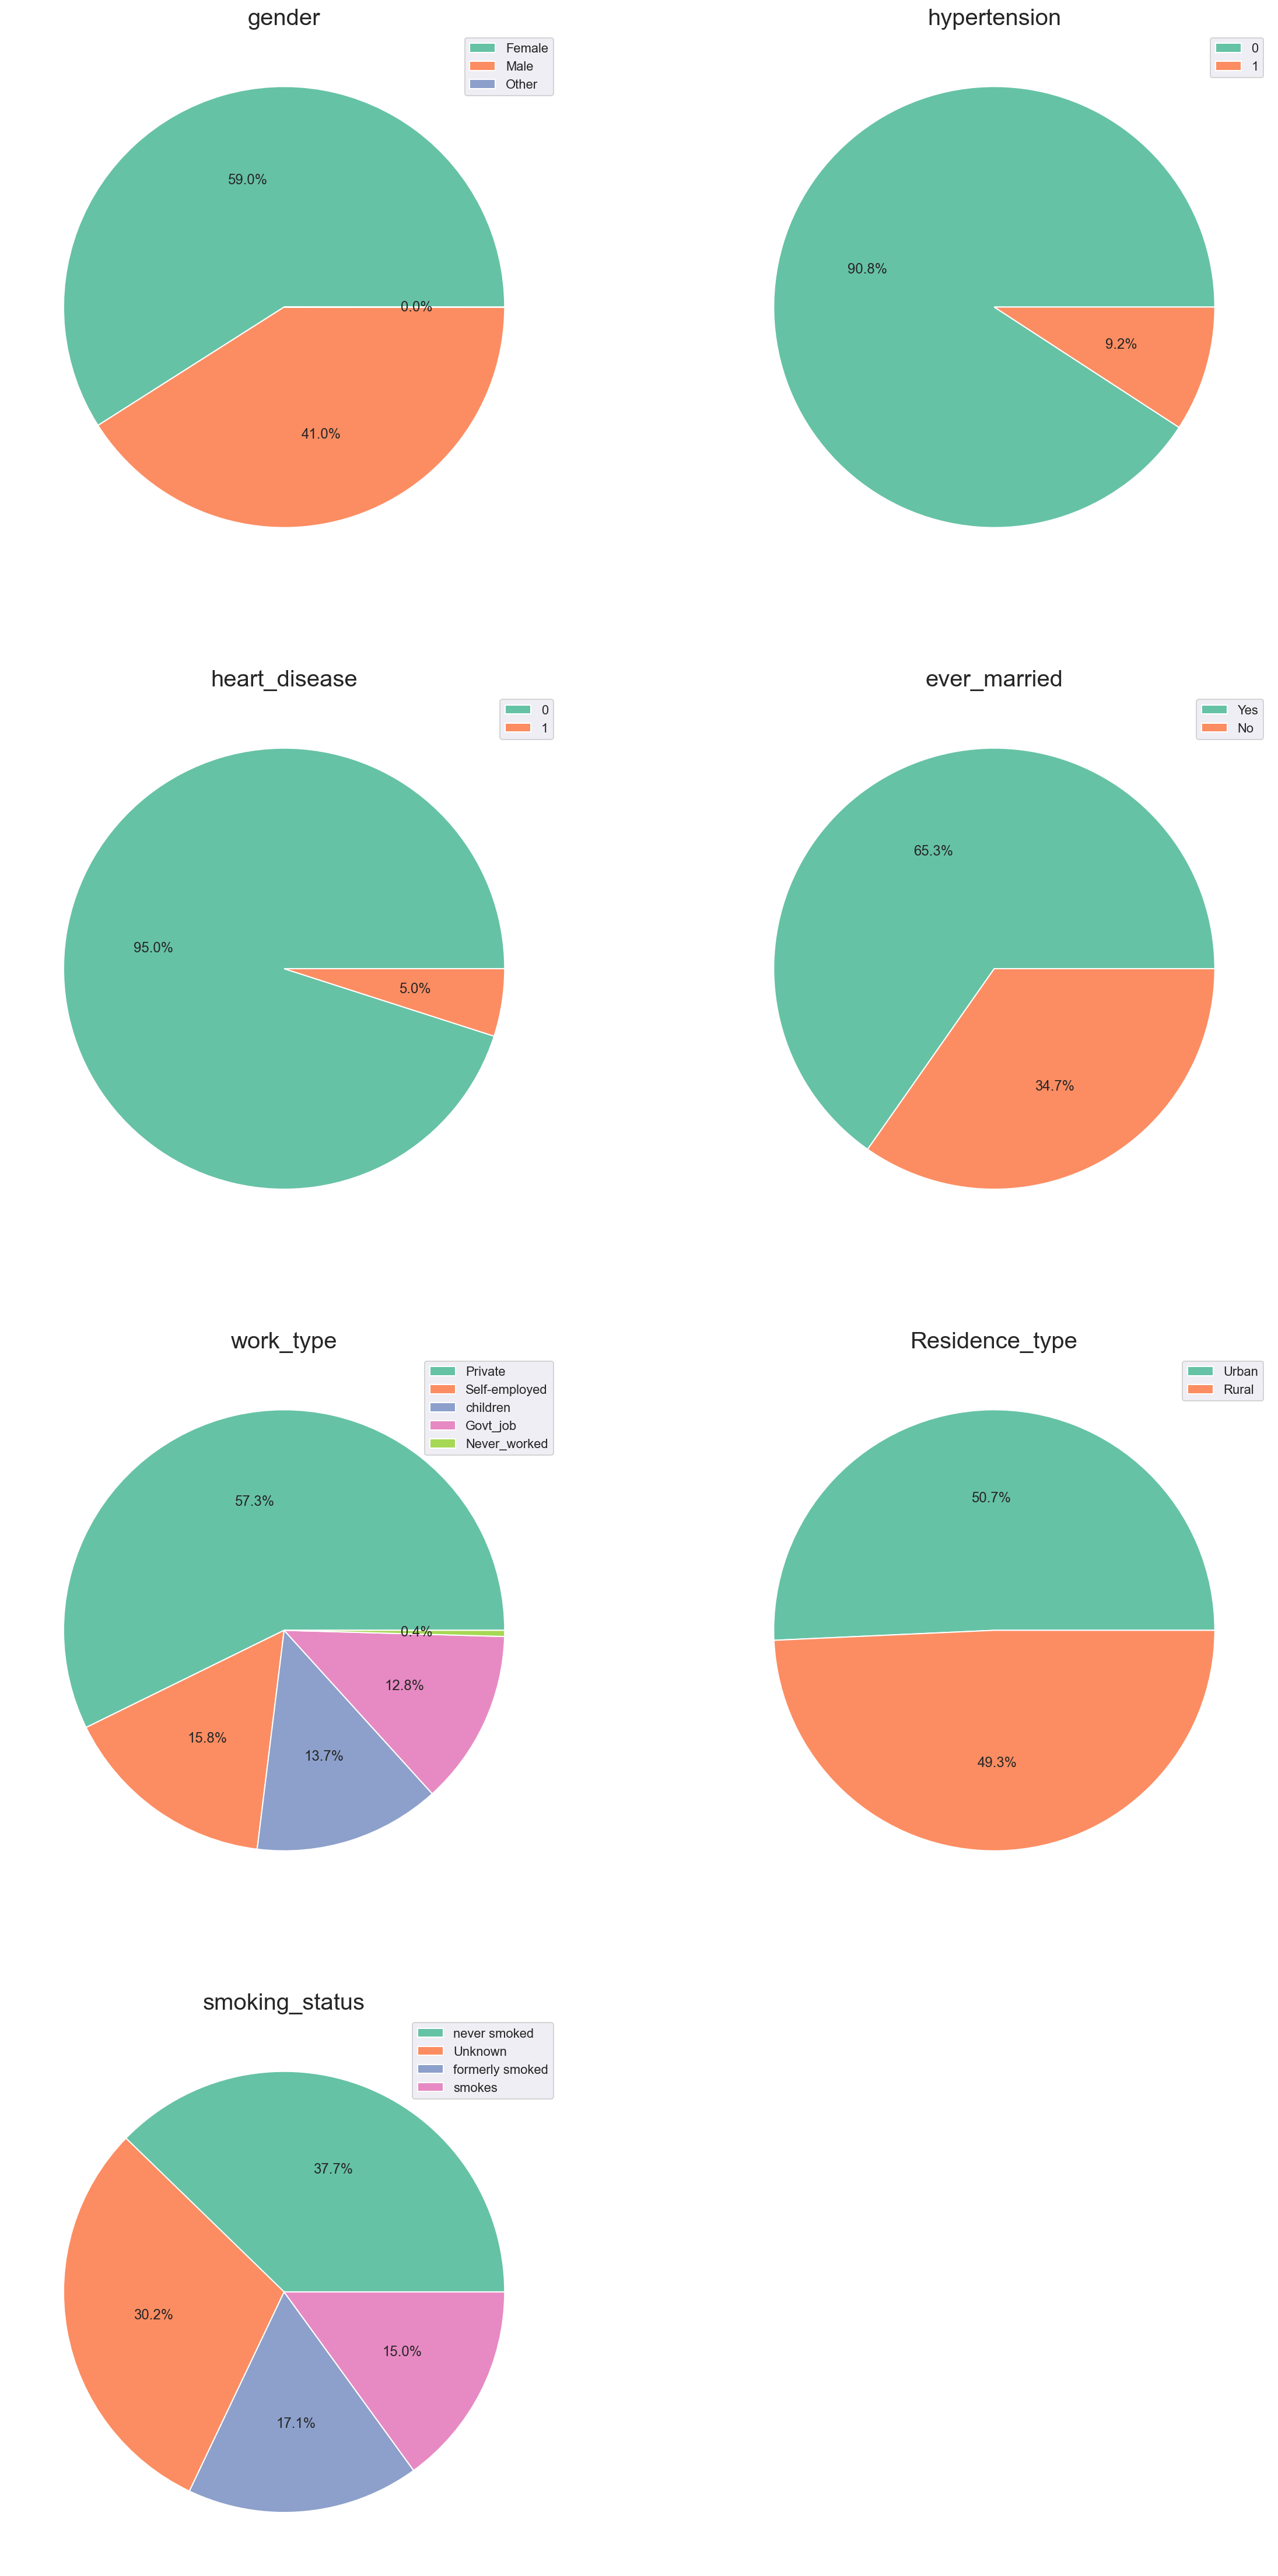

In [11]:
# пронаблюдаем круговые диаграммы для категориальных признаков
fig = plt.figure(figsize=(20,40)) 
for i in range(len(cat_cols)):
    data_i = data[cat_cols[i]].value_counts()
    plt.subplot(4, 2, i+1)
    plt.pie(data_i, autopct='%1.1f%%')
    plt.title(cat_cols[i], fontsize = 20)
    plt.legend(data_i.index, loc='best')

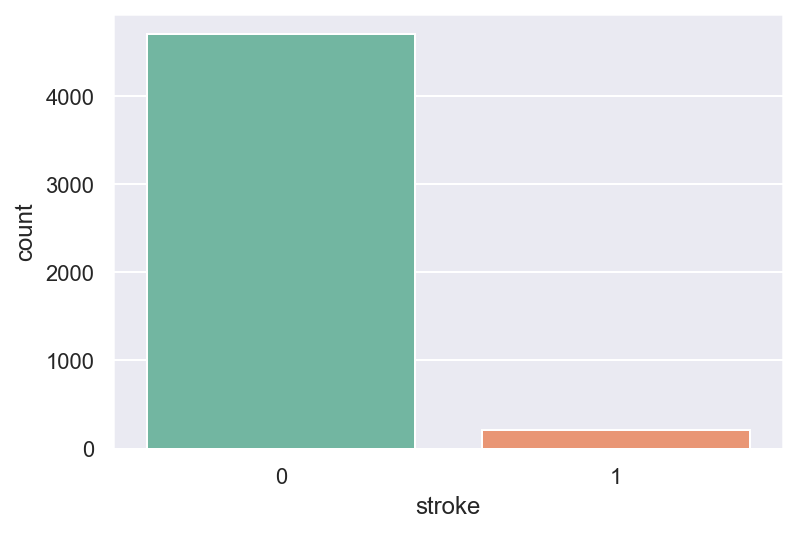

In [12]:
# посмотрим на распределение целевой переменной
ax = sns.countplot(x='stroke', data=data[target_col])

In [13]:
data[data[target_col] == 1].stroke.count() 

209

In [14]:
data[data[target_col] == 0].stroke.count()

4700

In [15]:
# несбалансированность классов 209 к 4700

In [16]:
# видим, что данные сильно несбалансированы по таргету
# в дальнейшем для сбалансирования будем использовать оверсэмплинг, чтобы модель не училась только на нулевом таргете
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

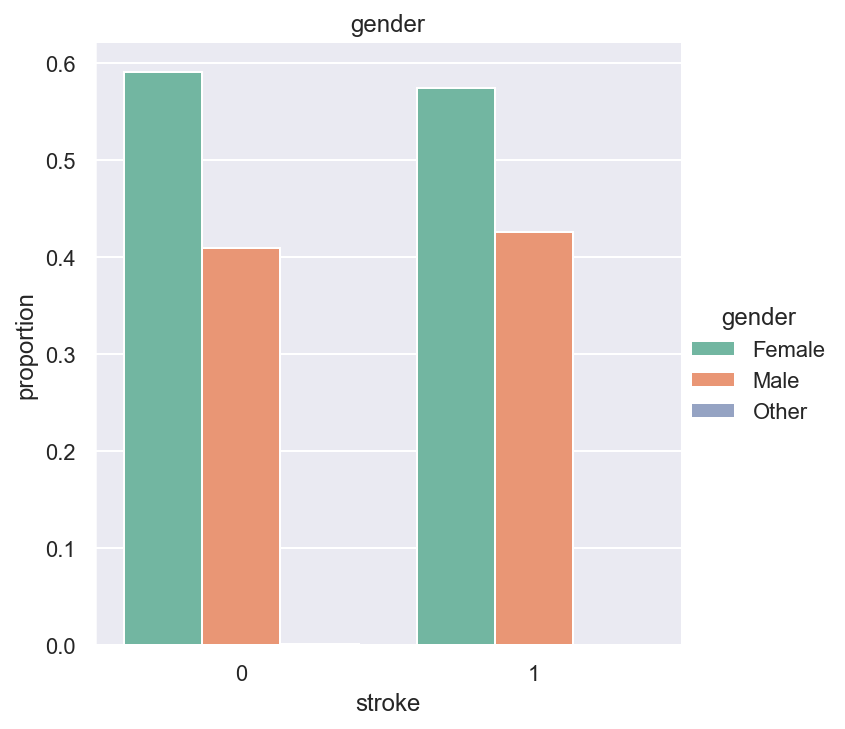

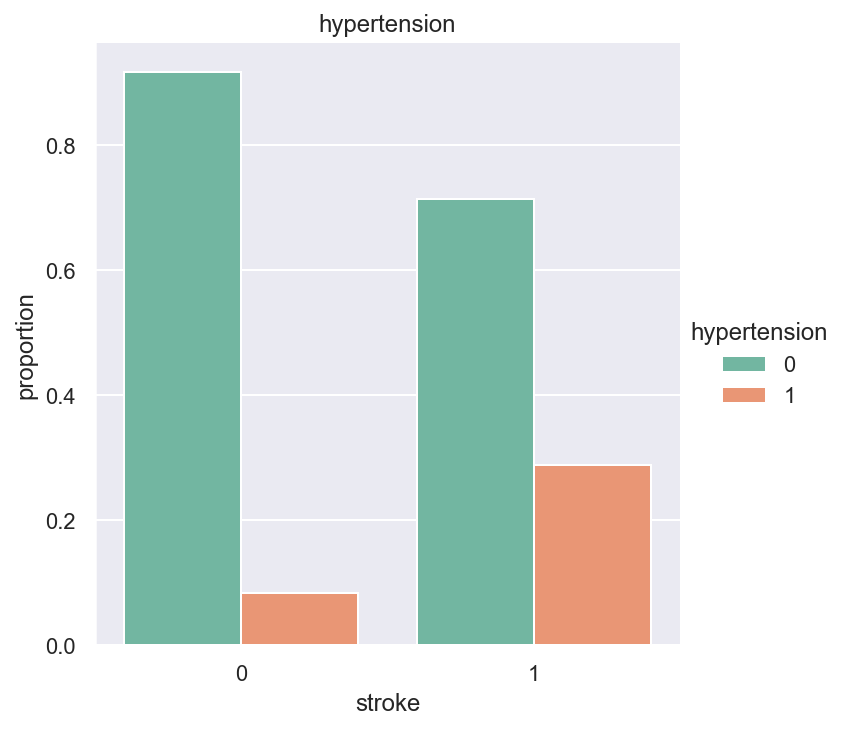

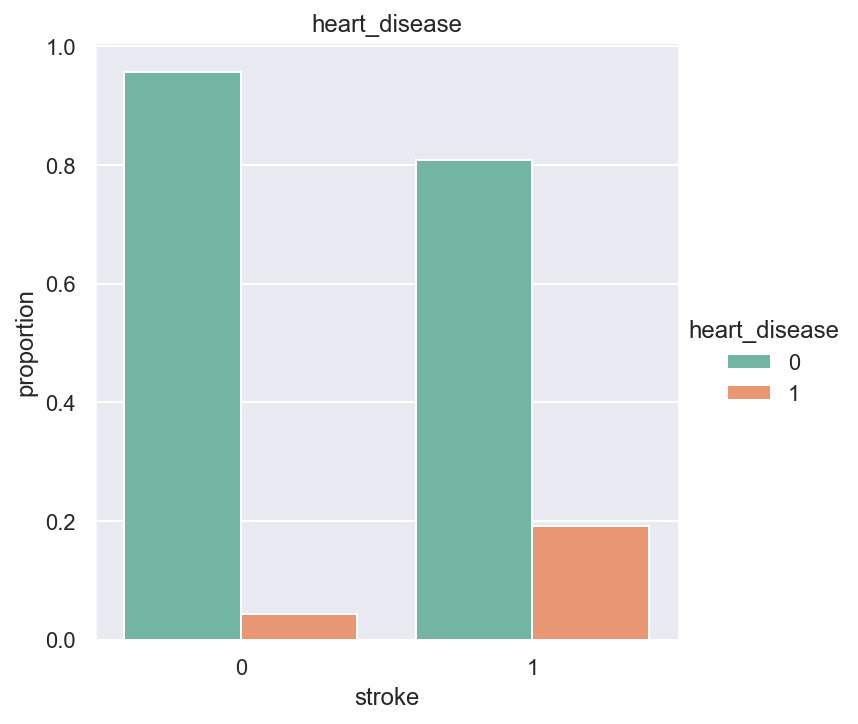

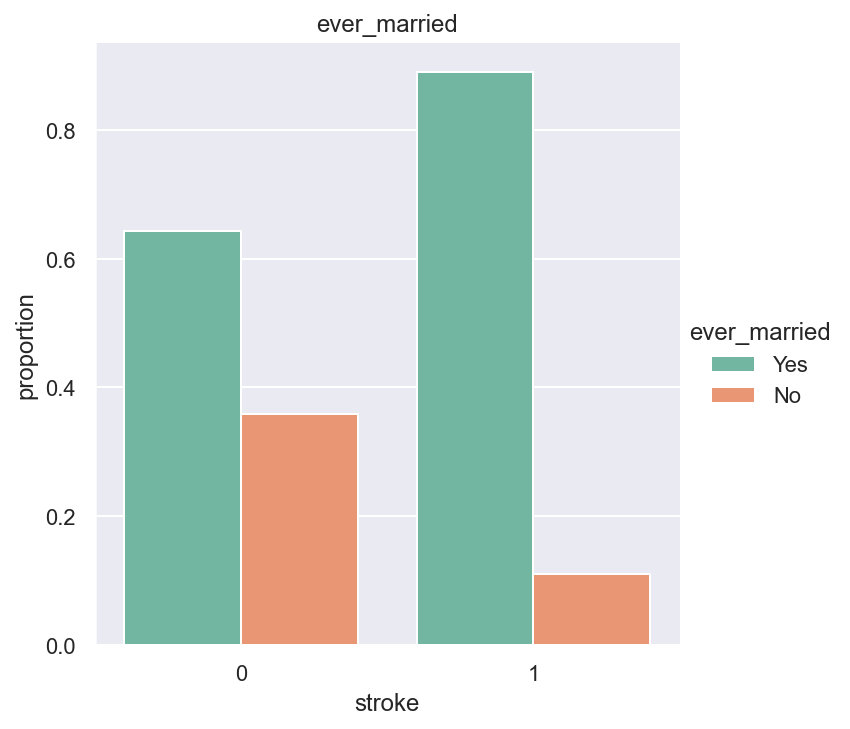

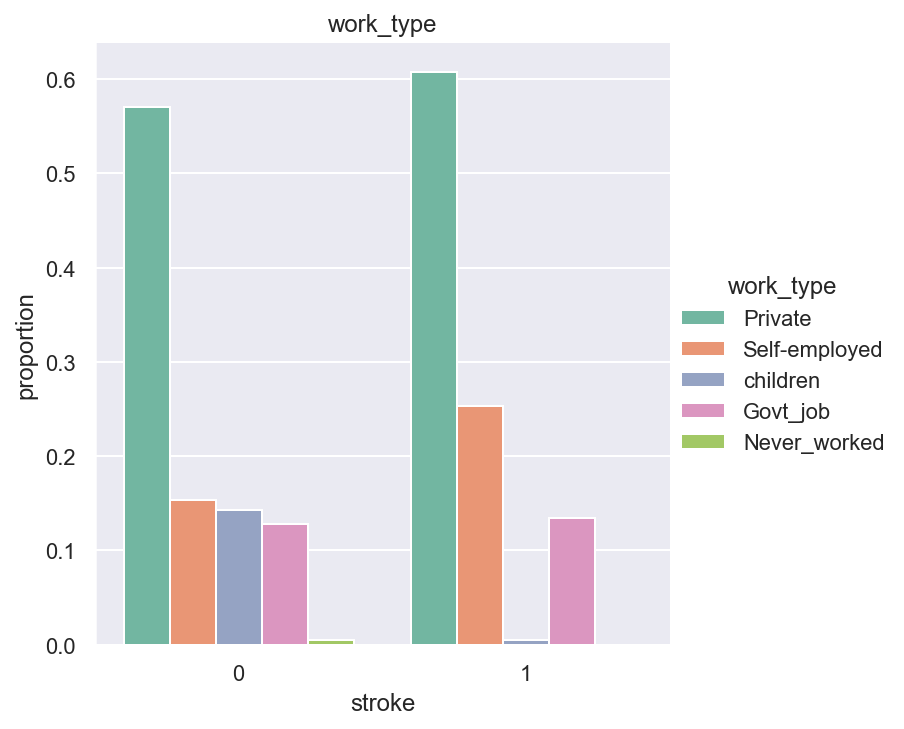

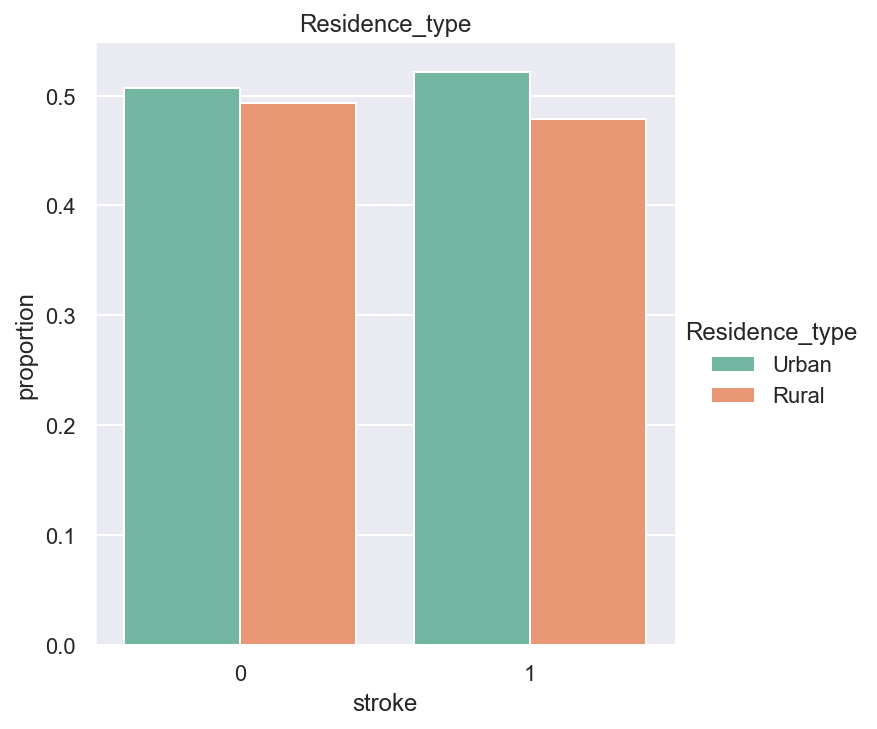

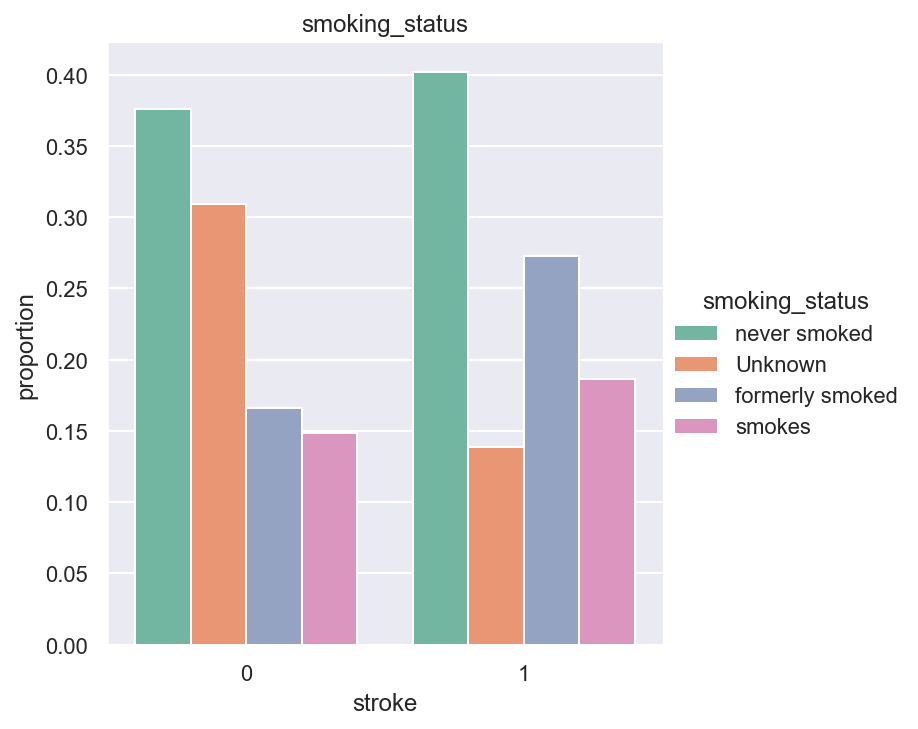

In [17]:
# Посмотрим распределения категориальных признаков относительно целевой переменной
for i, col_name in enumerate(data[cat_cols]):
    freq_data = data.groupby('stroke')[col_name].value_counts(normalize=True).rename('proportion').reset_index()
    sns.catplot(x='stroke', y='proportion', hue=col_name, kind='bar', data=freq_data)
    plt.title(col_name)
    plt.show()

In [18]:
# это функция отрисовки поможет нам в дальнешем следить за процессом подбора области гиперпараметров
def make_plot_of_results_of_grid_search_depends_on_param(hyperparam_name,
                                                         grid,
                                                         grid_cv):
    
    mean_test_score = []
    std_test_score = []
    mean_train_score = []
    std_train_score = []
    for mean_test, std_test, mean_train, std_train, params in zip(grid_cv.cv_results_['mean_test_score'],
                                                                  grid_cv.cv_results_['std_test_score'],
                                                                  grid_cv.cv_results_['mean_train_score'],
                                                                  grid_cv.cv_results_['std_train_score'],
                                                                  grid_cv.cv_results_['params']):
        flag = True
        for key, val in grid_cv.best_params_.items():
            if key != hyperparam_name:
                if params[key] != grid_cv.best_params_[key]:
                    flag = False
                    break
        
        if flag == False:
            continue
        
        mean_test_score += [mean_test]
        std_test_score += [std_test]
        mean_train_score += [mean_train]
        std_train_score += [std_train]
       
    mean_test_score = np.array(mean_test_score)
    std_test_score = np.array(std_test_score)
    mean_train_score = np.array(mean_train_score)
    std_train_score = np.array(std_train_score)
    plt.figure(figsize=(15,8))
    plt.title('GridSearchCV result for ' + str(grid_cv.estimator) + ' method')

    plt.plot(grid, mean_test_score, label='roc_auc test mean', color='blue', lw=3)
    plt.plot(grid, mean_train_score, label='roc_auc train mean', color='orange', lw=3)
        
    plt.fill_between(grid, mean_test_score - std_test_score, mean_test_score + std_test_score,
                     color='red', label='std error on test data', alpha=0.5)
    plt.fill_between(grid, mean_train_score - std_train_score, mean_train_score + std_train_score,
                     color='green', label='std error on train data', alpha=0.5)
    legend_box = plt.legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
    plt.xlabel(str(hyperparam_name))
    plt.ylabel('roc_auc value')
    plt.minorticks_on()
    plt.ylim([0, 1])
    plt.show()

In [19]:
# напишем функции вывода результатов
def cross_validation_info(grid_cv):
    print(f'Усреднённое качество на кроссвалидации при лучших гиперпараметрах: {grid_cv.best_score_:.3f}')
    print(f'Лучшие гиперпараметры: {grid_cv.best_params_}')
    print(f'Качество на трейне: {grid_cv.score(X_train, y_train):.3f}')
    print(f'Качество на отложенной выборке: {grid_cv.score(X_test, y_test):.3f}')

In [20]:
def scaled_cross_validation_info(grid_cv):
    print(f'Усреднённое качество на кроссвалидации при лучших гиперпараметрах: {grid_cv.best_score_:.3f}')
    print(f'Лучшие гиперпараметры: {grid_cv.best_params_}')
    print(f'Качество на трейне: {grid_cv.score(X_train_scaled, y_train):.3f}')
    print(f'Качество на отложенной выборке: {grid_cv.score(X_test_scaled, y_test):.3f}')

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

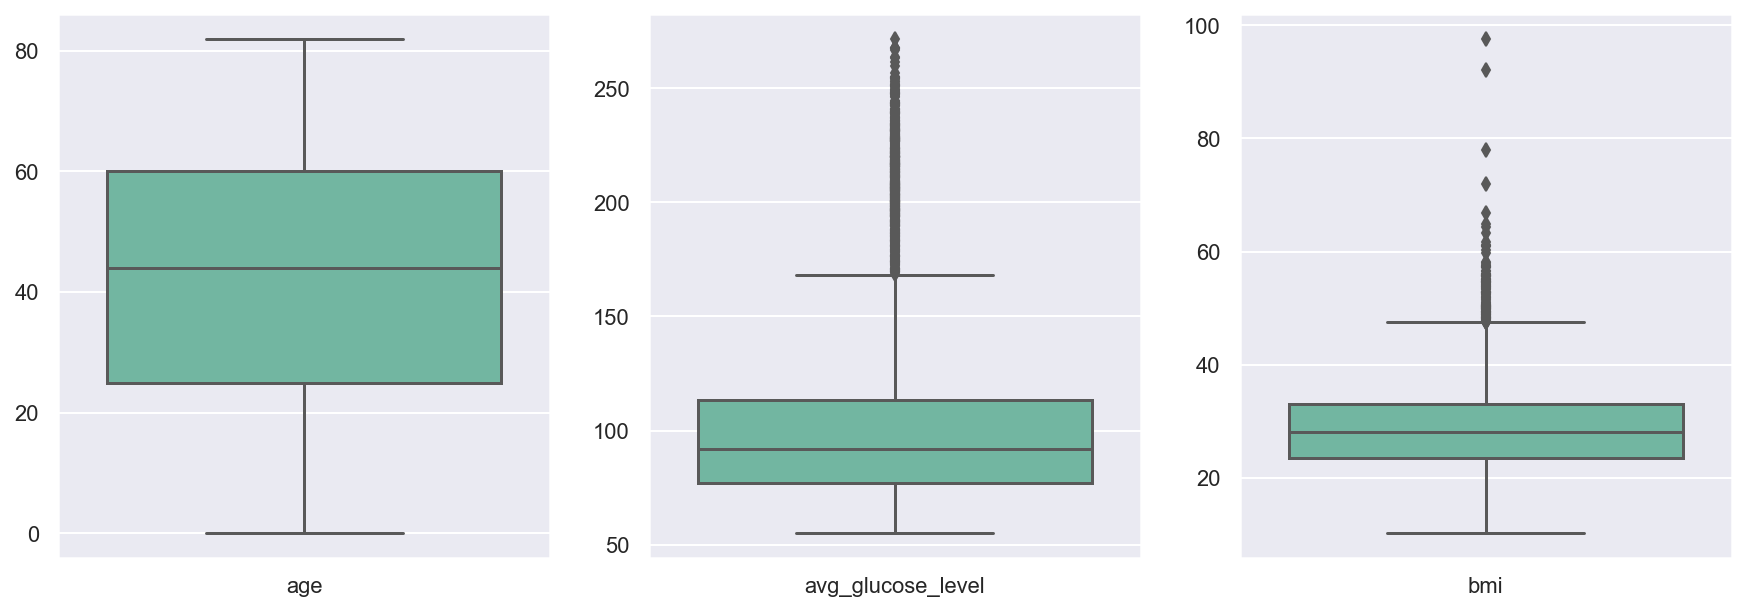

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.boxplot(data=data[[num_cols[0]]]);
plt.subplot(132)
sns.boxplot(data=data[[num_cols[1]]]);
plt.subplot(133)
sns.boxplot(data=data[[num_cols[2]]]);

In [24]:
Q1, Q3 = data['avg_glucose_level'].quantile([.25, .75])
IQR = Q3 - Q1
avg_glucose_level_lower = Q1 - 1.5*IQR
avg_glucose_level_upper = Q3 + 1.5*IQR

In [25]:
Q1, Q3 = data['bmi'].quantile([.25, .75])
IQR = Q3 - Q1
bmi_lower = Q1 - 1.5*IQR
bmi_upper = Q3 + 1.5*IQR

In [26]:
rows_to_drop = data[
    (data['avg_glucose_level'] < avg_glucose_level_lower) | (data['avg_glucose_level'] > avg_glucose_level_upper) | 
    (data['bmi']  < bmi_lower)  | (data['bmi']  > bmi_upper)].index
data_new = data.drop(rows_to_drop)

In [27]:
(data.shape[0] - data_new.shape[0]) / data.shape[0] * 100 # процентов выбросов

13.220615196577715

In [57]:
# избавимся от этих выбросов
data = data_new

In [30]:
X_num = data[num_cols]
y = data[target_col]

In [31]:
# категориальные признаки закодируем с помощью One hot encoding

In [32]:
data_categorial_features = pd.get_dummies(data[cat_cols])

In [33]:
data_categorial_features.head()

,hypertension,heart_disease,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
6,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
7,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0
9,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0
10,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0


In [34]:
data_categorial_features.isna().sum()

hypertension                      0
heart_disease                     0
gender_Female                     0
gender_Male                       0
gender_Other                      0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Rural              0
Residence_type_Urban              0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [35]:
data_numerical_features = data[num_cols]

In [36]:
X = pd.concat([data_numerical_features, data_categorial_features], axis=1)

In [37]:
X.head()

,age,avg_glucose_level,bmi,hypertension,heart_disease,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2,80.0,105.92,32.5,0,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
6,74.0,70.09,27.4,1,1,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
7,69.0,94.39,22.8,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
9,78.0,58.57,24.2,0,0,1,0,0,0,1,...,0,1,0,0,0,1,1,0,0,0
10,81.0,80.43,29.7,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0


In [38]:
y = data[target_col]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train.shape, y_train.shape

((5774, 21), (5774, 1))

In [40]:
# скалируем признаки
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

KNN

In [41]:
# по умолчанию если cv опущен, то cv идёт по 5 фолдам
param_grid = {'n_neighbors': np.arange(1, 61, 6),
              'p': [1, 2],
              'weights': ['uniform', 'distance']}

knn_grid_cv = GridSearchCV(KNeighborsClassifier(),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           return_train_score=True)
knn_grid_cv.fit(X_train_scaled, y_train);

In [42]:
grid_cv = knn_grid_cv
grid_cv.fit(X_train_scaled, y_train)
scaled_cross_validation_info(grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.996
Лучшие гиперпараметры: {'n_neighbors': 55, 'p': 1, 'weights': 'distance'}
Качество на трейне: 1.000
Качество на отложенной выборке: 0.681


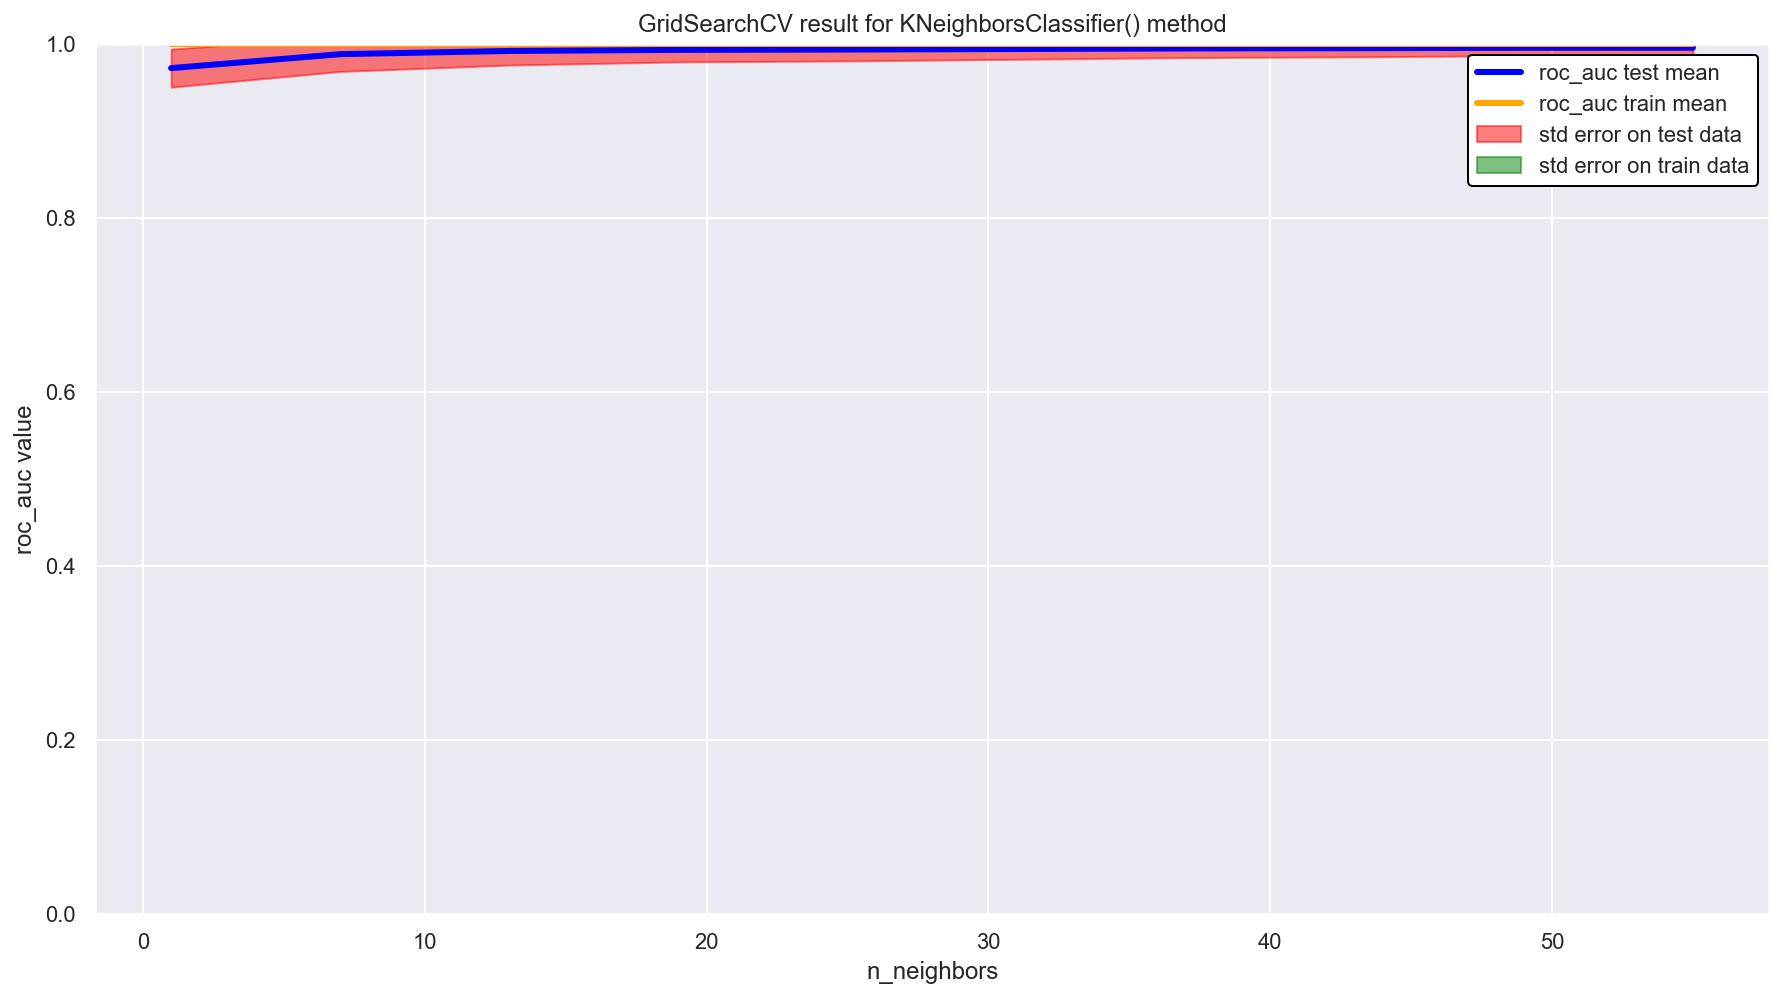

In [43]:
make_plot_of_results_of_grid_search_depends_on_param(hyperparam_name='n_neighbors',
                                                     grid=np.arange(1, 61, 6),
                                                     grid_cv=knn_grid_cv)

DecisionTree

In [44]:
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 30, 1)}

decision_tree_grid_cv = GridSearchCV(DecisionTreeClassifier(),
                                     param_grid=param_grid,
                                     scoring='roc_auc',
                                     n_jobs=-1,
                                     return_train_score=True)
decision_tree_grid_cv.fit(X_train_scaled, y_train);

In [45]:
grid_cv = decision_tree_grid_cv
grid_cv.fit(X_train_scaled, y_train)
scaled_cross_validation_info(grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.978
Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 8}
Качество на трейне: 0.994
Качество на отложенной выборке: 0.690


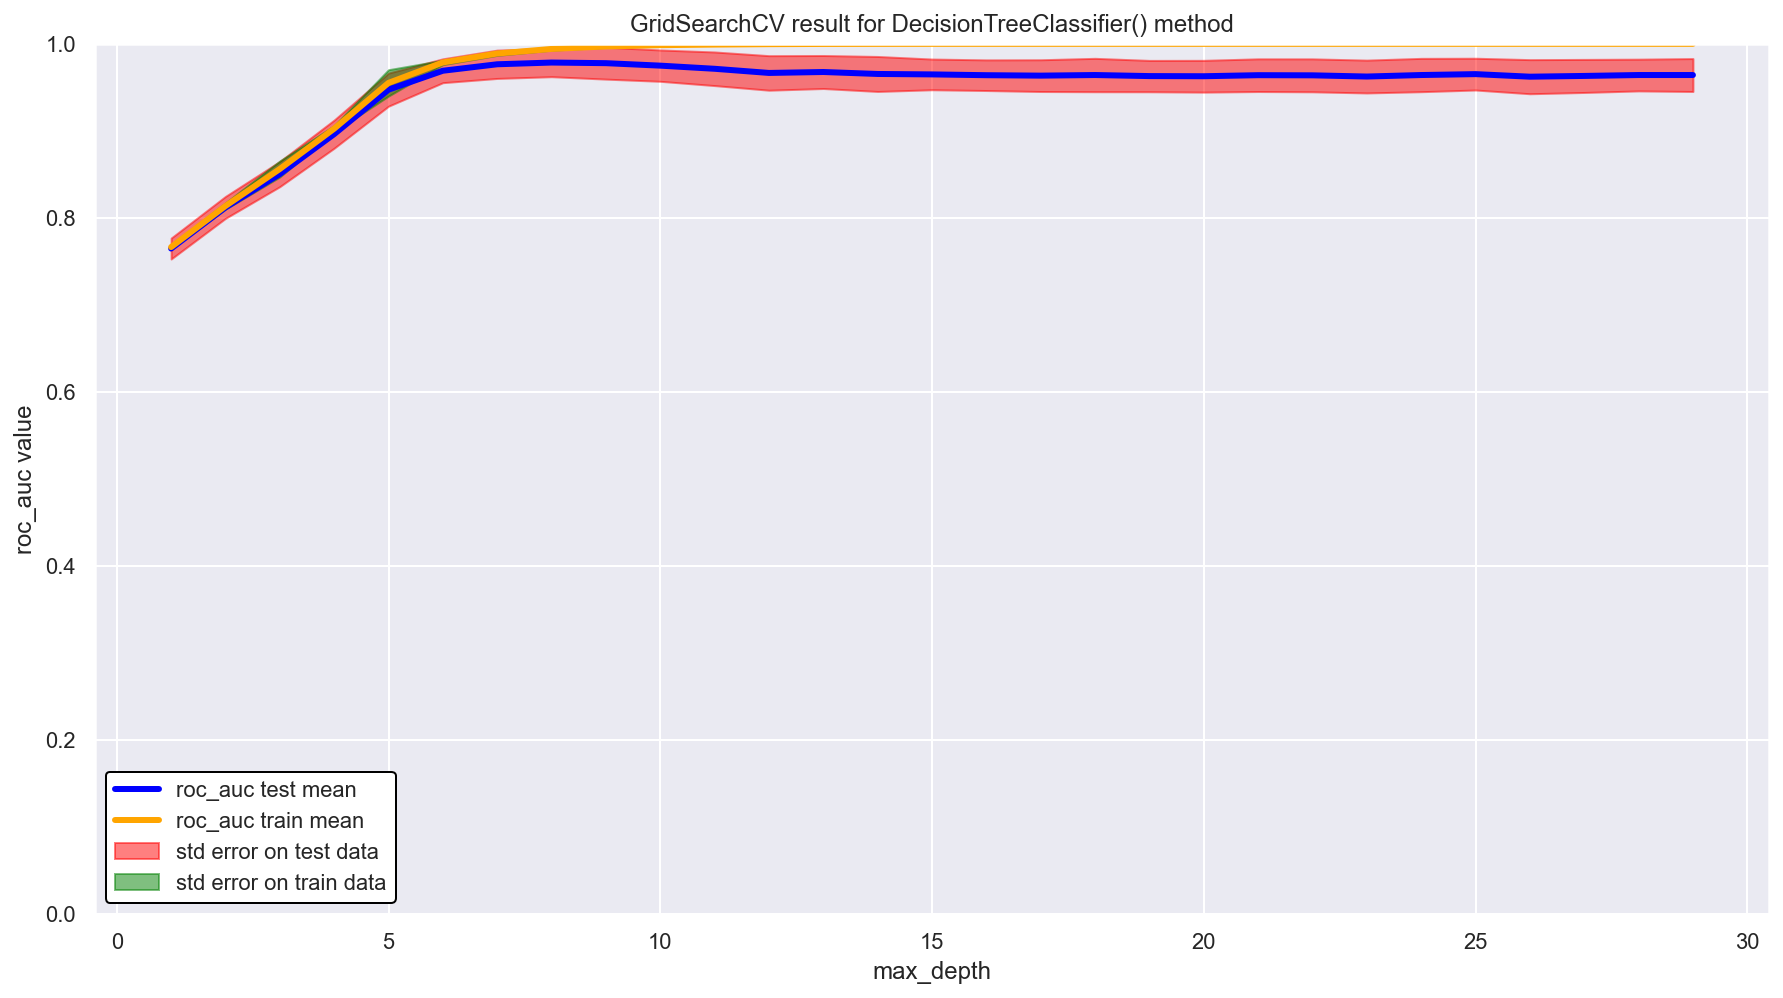

In [46]:
make_plot_of_results_of_grid_search_depends_on_param(hyperparam_name='max_depth',
                                                     grid=np.arange(1, 30, 1),
                                                     grid_cv=decision_tree_grid_cv)

LogisticRegression

In [47]:
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': [0.0001, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}

log_reg_grid_cv = GridSearchCV(LogisticRegression(),
                               param_grid=param_grid,
                               scoring='roc_auc',
                               n_jobs=-1,
                               return_train_score=True)
log_reg_grid_cv.fit(X_train_scaled, y_train);

In [48]:
grid_cv = log_reg_grid_cv
grid_cv.fit(X_train_scaled, y_train)
scaled_cross_validation_info(grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.991
Лучшие гиперпараметры: {'C': 0.1, 'penalty': 'l2'}
Качество на трейне: 0.993
Качество на отложенной выборке: 0.825


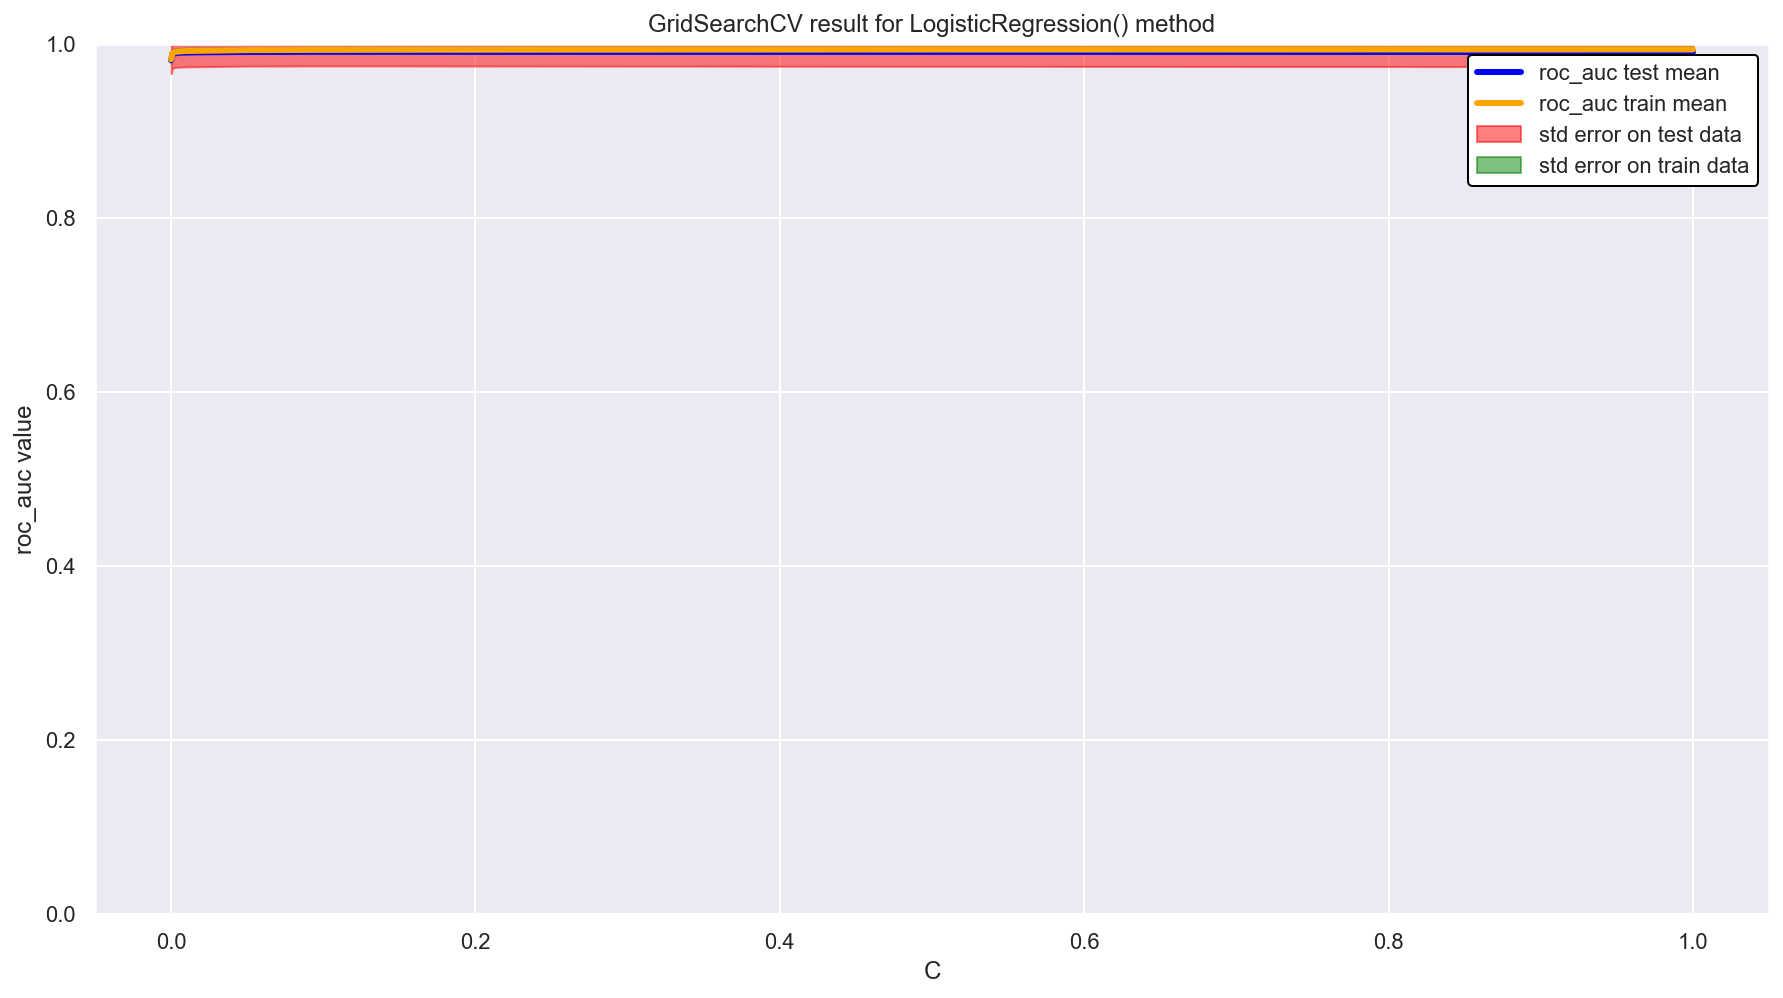

In [49]:
make_plot_of_results_of_grid_search_depends_on_param(hyperparam_name='C',
                                                     grid=[0.0001, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                                                     grid_cv=log_reg_grid_cv)

SVC

In [50]:
param_grid = {'kernel': ['sigmoid'],
              'C': [0.0001, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}

svc_grid_cv = GridSearchCV(SVC(),
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           return_train_score=True)
svc_grid_cv.fit(X_train_scaled, y_train);

In [51]:
grid_cv = svc_grid_cv
grid_cv.fit(X_train_scaled, y_train)
scaled_cross_validation_info(grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.989
Лучшие гиперпараметры: {'C': 0.01, 'kernel': 'sigmoid'}
Качество на трейне: 0.990
Качество на отложенной выборке: 0.820


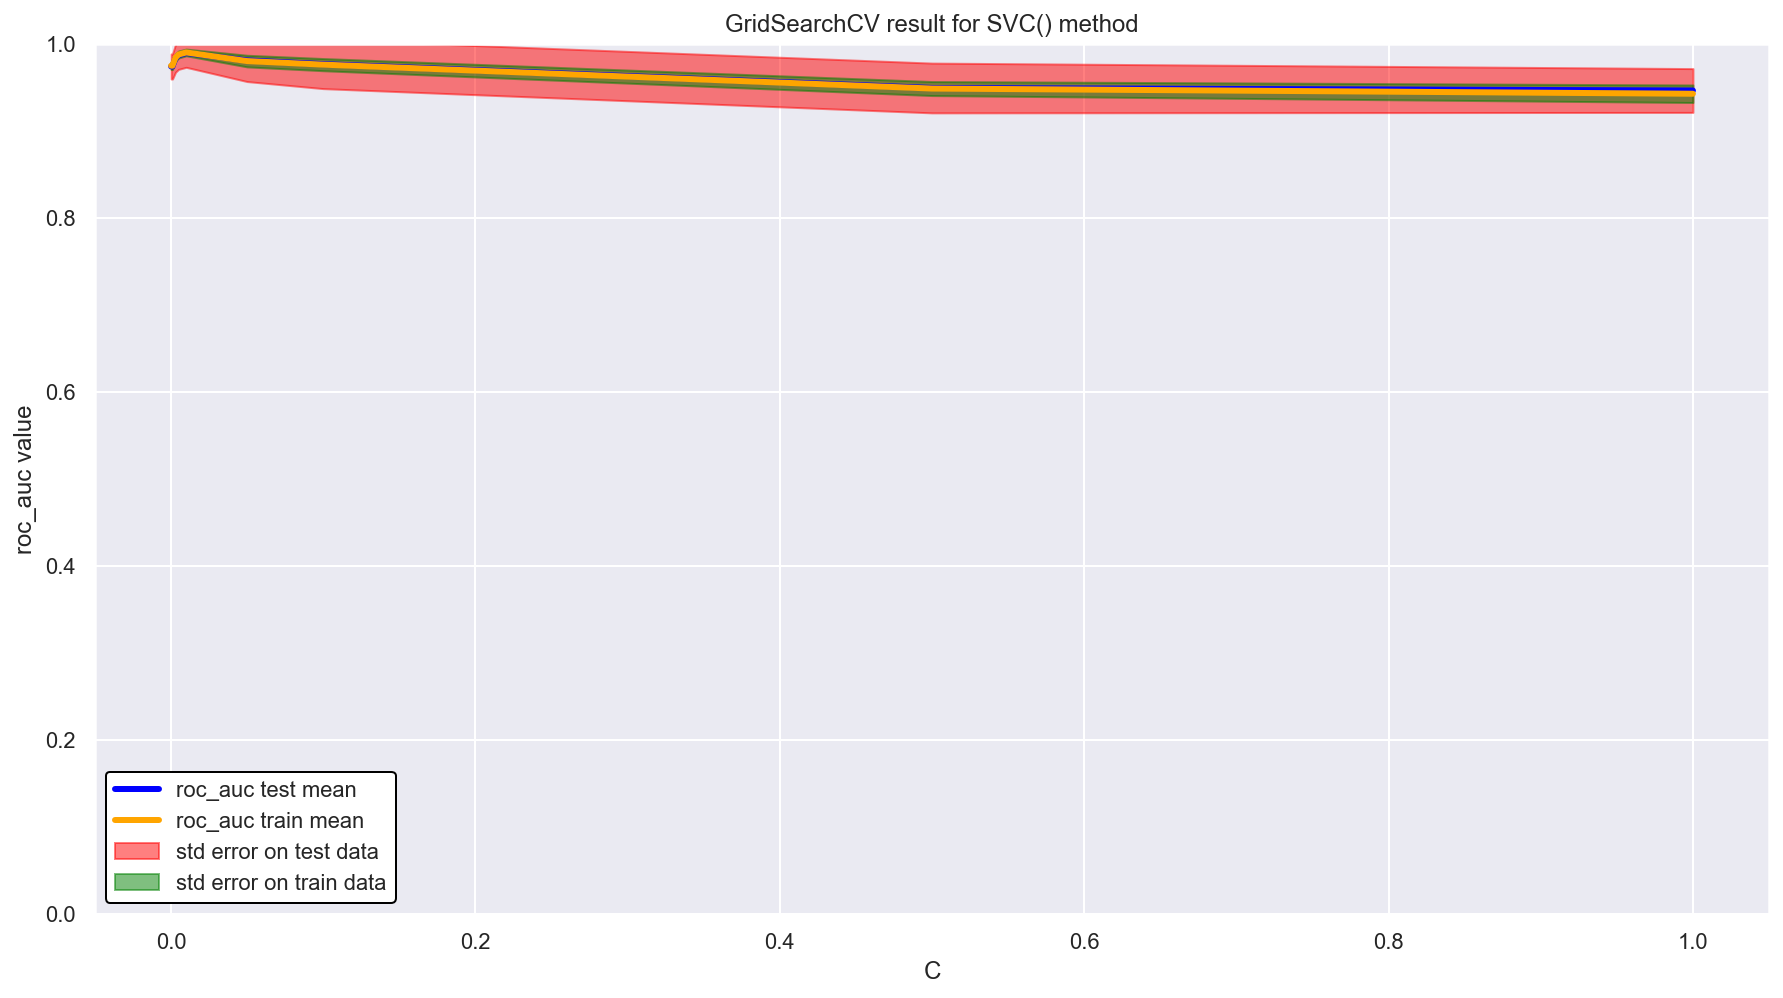

In [52]:
make_plot_of_results_of_grid_search_depends_on_param(hyperparam_name='C',
                                                     grid=[0.0001, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                                                     grid_cv=svc_grid_cv)

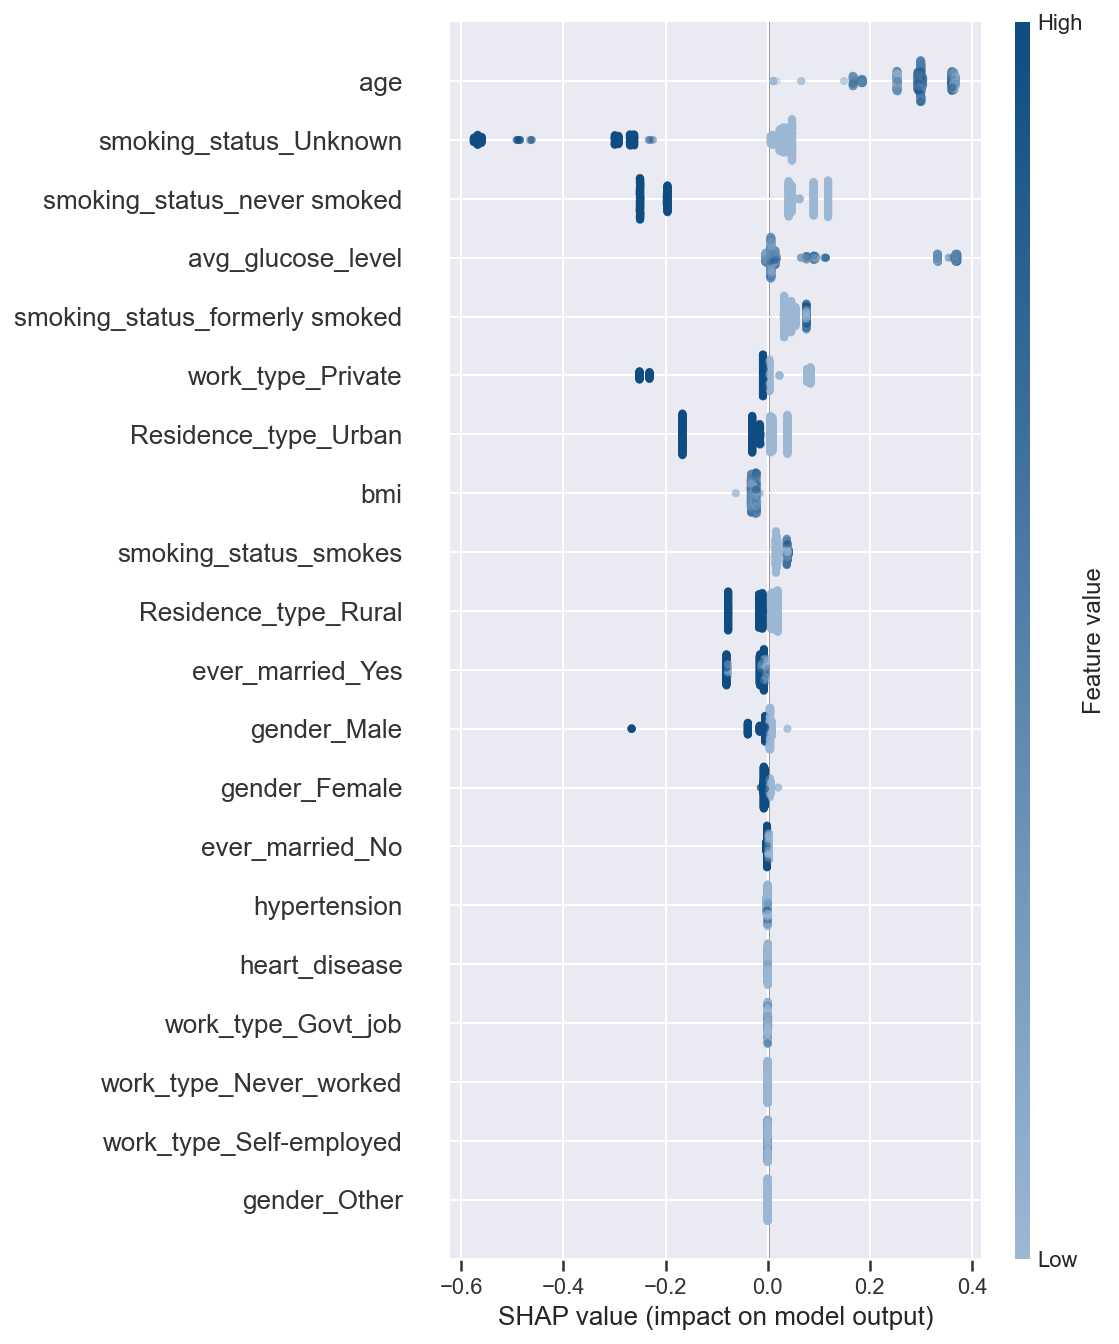

In [53]:
# Пронаблюдаем значимости признаков на основании влкада в изменение энтропии
import shap  

fc = DecisionTreeClassifier(criterion=decision_tree_grid_cv.best_params_['criterion'], 
                            max_depth=decision_tree_grid_cv.best_params_['max_depth'])
fc.fit(X_train_scaled, y_train)

explainer = shap.TreeExplainer(fc)
shap_values = explainer.shap_values(X_test)

colors = ["#9bb7d4", "#0f4c81"]           
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values[1], X_test,cmap=cmap,alpha=0.4)

Видим, что доминирующую роль в риске инсульта играет Возраст. А также важную роль имеет Курение и Средний уровень глюкозы в крови.

RandomForest

In [54]:
# RandomForestClassifier 

lst = [100, 200, 300]
param_grid = {'n_estimators': lst}

random_forest_grid_cv = GridSearchCV(RandomForestClassifier(),
                                     param_grid=param_grid,
                                     scoring='roc_auc',
                                     n_jobs=-1,
                                     return_train_score=True)
random_forest_grid_cv.fit(X_train_scaled, y_train);

In [55]:
cross_validation_info(random_forest_grid_cv)

Усреднённое качество на кроссвалидации при лучших гиперпараметрах: 0.999
Лучшие гиперпараметры: {'n_estimators': 200}
Качество на трейне: 0.951
Качество на отложенной выборке: 0.494


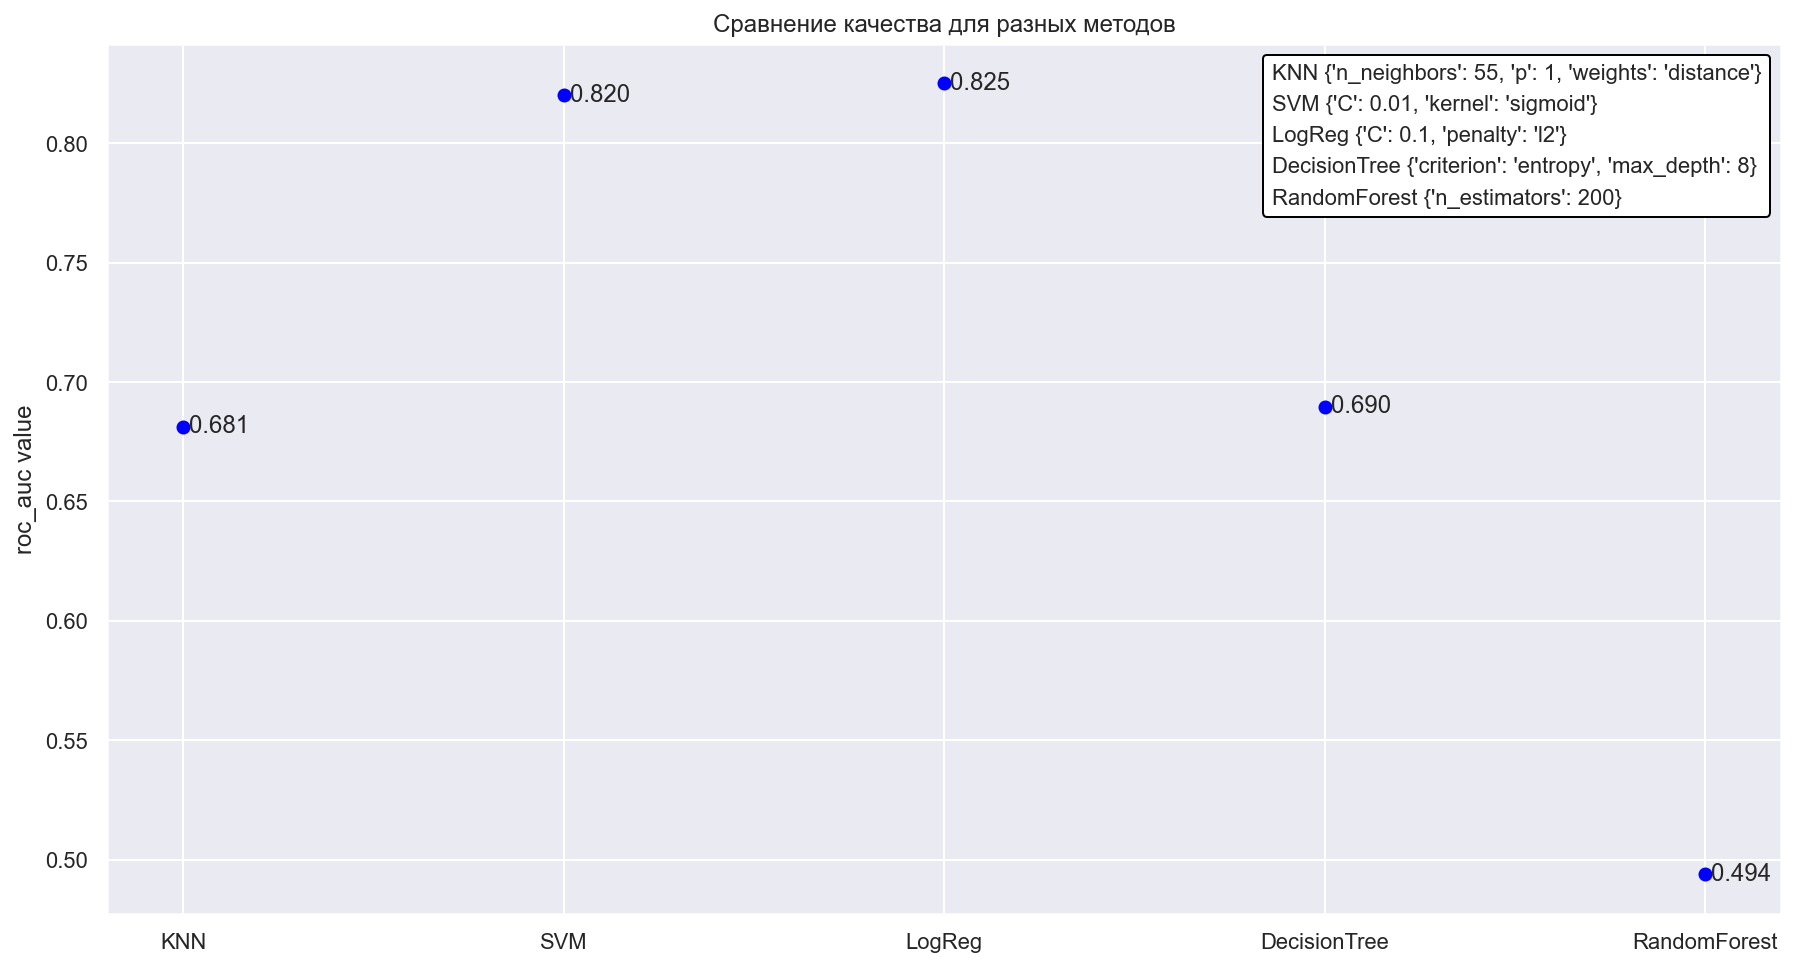

In [56]:
# визуализируем результаты работы всех алгоритмов при их лучших гиперпараметрах

plt.figure(figsize=(15,8))
plt.title('Сравнение качества для разных методов')


plt.plot('KNN', knn_grid_cv.score(X_test_scaled, y_test),'bo', label='KNN ' + f'{knn_grid_cv.best_params_}', )
plt.plot('SVM', svc_grid_cv.score(X_test_scaled, y_test),'bo', label='SVM ' + f'{svc_grid_cv.best_params_}')
plt.plot('LogReg', log_reg_grid_cv.score(X_test_scaled, y_test),'bo', label='LogReg ' + f'{log_reg_grid_cv.best_params_}')
plt.plot('DecisionTree', decision_tree_grid_cv.score(X_test_scaled, y_test),'bo', label='DecisionTree ' + f'{decision_tree_grid_cv.best_params_}')
plt.plot('RandomForest', random_forest_grid_cv.score(X_test, y_test),'bo', label='RandomForest ' + f'{random_forest_grid_cv.best_params_}')
plt.ylabel('roc_auc value')

scores = [knn_grid_cv.score(X_test_scaled, y_test),
         svc_grid_cv.score(X_test_scaled, y_test),
         log_reg_grid_cv.score(X_test_scaled, y_test),
          decision_tree_grid_cv.score(X_test_scaled, y_test),
         random_forest_grid_cv.score(X_test, y_test)]

for i, v in enumerate(scores):
    plt.annotate(f'{v:.3f}', xy=(i,v), xytext=(3,-3), textcoords='offset points')

legend_box = plt.legend(handletextpad=-2.0, markerscale=0, framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")

plt.minorticks_on()
plt.show()

Лучшее качество ROC AUC показали Логистическая регрессия и Метод опорных векторов.